# Проект

## Постановка задачи

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
Нужно построить модель с предельно большим значением F1-меры. Это значение должно быть не меньше, чем 0.59. Помимо F1-меры необходимо посчитать значение метрики AUC-ROC.

## Изучение и подготовка данных

In [1]:
import pandas as pd
import os
import warnings
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, accuracy_score
from itertools import product, combinations
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier

pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
is_need_learn = False

Откроем файл с данными и изучим его

In [2]:
def open_file(filename, indexcol=None):
    path_home = './data/' + filename
    path_server = '/datasets/' + filename
    path_full = filename
    if os.path.exists(path_home):
        return pd.read_csv(path_home, index_col=indexcol)
    elif os.path.exists(path_server):
        return pd.read_csv(path_server, index_col=indexcol)
    elif os.path.exists(path_full):
        return pd.read_csv(path_full, index_col=indexcol)
    else:
        raise FileNotFoundError("cannot find file " + filename)

In [3]:
data = open_file('Churn_Modelling.csv', 0)

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


В таблице 10000 строк и 14 столбцов. Пропусков нет. Последний столбец (_Exitted_) будет использоваться как целевой признак, а все остальные, кроме столбцов _CustomerId_ и _Surname_ - как обычные признаки для обучения моделей.

In [5]:
print('Доля клиентов, перешедших на тариф ultra:', data[data['Exited'] == 1]['Exited'].count()/data['Exited'].count())
print('Доля клиентов, перешедших на тариф ultra:', data[data['Exited'] == 0]['Exited'].count()/data['Exited'].count())

Доля клиентов, перешедших на тариф ultra: 0.2037
Доля клиентов, перешедших на тариф ultra: 0.7963


Соотношение признаков примерно 1 к 4. Довольно ощутимая разница, которая может повлиять на обучение и результаты, если мы будем обучать модель ровно на наших данных без каких-либо изменений. Вероятно, нам придется отредактировать данные для более корректного обучения.

Преобразуем категориальные признаки в численные с помощью one-head encoding. Всего у нас 2 категориальных признака - столбец _Genre_ с двумя возможными значениями и столбец _Geography_ с тремя возможными значениями. Поэтому после преобразования мы удалим два старых столбца и сгенерируем три новых, что не приведет к раздуванию таблицы.

In [6]:
data_ohe = pd.get_dummies(data.loc[:, (data.columns != 'CustomerId') & (data.columns != 'Surname')], drop_first=True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
2,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
3,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
4,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
5,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Определим обучающую, валидационную и тестовую выборки. Соотношение будет 3:1:1. Для каждой выборки сохраним соотношение признаков.

In [7]:
features_1 = data_ohe[data_ohe['Exited'] == 1].loc[:, data_ohe.columns != 'Exited']
target_1 = data_ohe[data_ohe['Exited'] == 1]['Exited']
features_0 = data_ohe[data_ohe['Exited'] == 0].loc[:, data_ohe.columns != 'Exited']
target_0 = data_ohe[data_ohe['Exited'] == 0]['Exited']

main_features_1, test_features_1, main_target_1, test_target_1 = train_test_split(features_1, target_1, test_size=0.2, random_state=12345)
main_features_0, test_features_0, main_target_0, test_target_0 = train_test_split(features_0, target_0, test_size=0.2, random_state=12345)

train_features_1, valid_features_1, train_target_1, valid_target_1 = train_test_split(main_features_1, main_target_1, test_size=0.25, random_state=12345)
train_features_0, valid_features_0, train_target_0, valid_target_0 = train_test_split(main_features_0, main_target_0, test_size=0.25, random_state=12345)

main_features = pd.concat([main_features_1, main_features_0])
train_features = pd.concat([train_features_1, train_features_0])
test_features = pd.concat([test_features_1, test_features_0])
valid_features = pd.concat([valid_features_1, valid_features_0])
main_target = pd.concat([main_target_1, main_target_0])
train_target = pd.concat([train_target_1, train_target_0])
test_target = pd.concat([test_target_1, test_target_0])
valid_target = pd.concat([valid_target_1, valid_target_0])

print('Train sample size', train_features.shape[0])
print('Test sample size', test_features.shape[0])
print('Test sample size', valid_features.shape[0])

Train sample size 5998
Test sample size 2001
Test sample size 2001


Определим массив числовых признаков и нормируем эти признаки. 

In [8]:
# столбцы 'HasCrCard' и 'IsActiveMember' численные, но имеют значения 0 и 1
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(train_features[numeric])

train_features[numeric] = scaler.transform(train_features[numeric])
valid_features[numeric] = scaler.transform(valid_features[numeric])

scaler = StandardScaler()
scaler.fit(main_features[numeric])
main_features[numeric] = scaler.transform(main_features[numeric])
test_features[numeric] = scaler.transform(test_features[numeric])

print(train_features.shape)
print(valid_features.shape)
print(test_features.shape)
display(train_features.head())
display(valid_features.head())
test_features.head()

(5998, 11)
(2001, 11)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,
4730,0.345763,0.303605,-0.35107,1.143057,-0.914176,1,1,-0.967680,0,0,0
5389,-0.782942,1.456758,-1.38871,0.362816,-0.914176,0,0,-1.663127,1,0,1
1220,0.449314,0.495797,-0.00519,0.762143,0.805783,1,1,-0.927391,1,0,1
6233,0.780677,0.784085,-1.38871,0.445054,-0.914176,0,0,-0.234951,1,0,0
3338,-0.731166,1.648950,-0.35107,0.355841,-0.914176,0,0,-1.669634,0,1,1


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,
2696,-0.544775,0.015316,1.03245,1.372230,2.525741,1,0,-1.118685,1,0,0
5536,-0.016665,-0.657356,1.03245,1.285485,2.525741,1,0,1.588956,1,0,0
521,2.075063,-0.369068,-1.38871,2.164257,-0.914176,1,0,1.546660,0,0,0
9211,-2.771119,-0.272972,-1.73459,-1.241989,-0.914176,1,1,1.388801,0,1,1
7557,0.915293,0.976277,-0.69695,-1.241989,2.525741,1,1,-0.611645,0,1,1


Так как в выборке наблюдается значительный дизбаланс классов, создадим сбалансированные выборки - с помощью расширения и с помощью сужения исходной.

In [9]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [10]:
features_upsampled, target_upsampled = upsample(train_features, train_target, 4)
print('Upsampled train sample size', features_upsampled.shape[0])
print('Class 1', features_upsampled[target_upsampled == 1].shape[0])
print('Class 2', features_upsampled[target_upsampled == 0].shape[0])

Upsampled train sample size 9661
Class 1 4884
Class 2 4777


In [11]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [12]:
features_downsampled, target_downsampled = downsample(train_features, train_target, 0.26)
print('Downsampled train sample size', features_downsampled.shape[0])
print('Class 1', features_downsampled[target_downsampled == 1].shape[0])
print('Class 2', features_downsampled[target_downsampled == 0].shape[0])

Downsampled train sample size 2463
Class 1 1221
Class 2 1242


Теперь определим список всевозможных комбинаций признаков.

In [13]:
features_list = []

for i in range(11, 12):
    comb = list(combinations(train_features[2:12].columns, i))
    for a in comb:
        features_list.append(list(a))
    
len(features_list)

1

Мы подготовили данные для обучения моделей.

## Обучение и исследование моделей

Мы будем использовать два алгоритма классификации в чистом виде с различными гиперпараметрами: решающее дерево и логистическую регрессию. Для каждого алгоритма обучим несколько моделей с разными гиперпараметрами, использующих различные комбинации признаков. Обучение проведем на трех типах данных - на исходной выборке с дисбалансом классов, а также на сбалансированных выборках, полученных расширением или сужением исходной.

При обучении на исходной выборке мы будем использовать grid search и его реализацию в sklearn - это просто и удобно.
Для обучения на остальных выборках пользоваться им будет некорректно - нам нужно обучиться на модифицированной выборке со сбалансированными классами, а затем проверить модели на несбалансированной валидационной выборке, в то время как GridSearchCV проводит кросс-валидацию на всем выбранном наборе и самостоятельно проводит разбиение - мы не сможем ему указать обучаться на сбалансированных данных и проверять метрики на несбалансированных. 

Поясним также алгоритм выбора набора признаков. Суммарно всевозможных выборки признаков без повторений 2047 - мы просто не сможем обучить модели на всех таких выборках. Поэтому будем использовать жадный алгоритм. 


1) Определим переменную cur_features_list как список, состоящий из одного элемента - списка всех признаков. Определим cur_best_model_score как -1.

2) На каждом элементе cur_features_list определим лучшую модель на указанном множестве гиперпараметров (с помощью GridSearchCV или руками). Получим множество моделей, из которых выберем лучшую. Ее значение F1-score запишем в переменную iter_best_model_score, а признаки, на которых она была обучена - в переменную iter_best_model_feat

3) Если iter_best_model_score больше, чем cur_best_model_score - переопределим cur_features_list как множество всех выборок без повторений на элементах iter_best_model_feat размера _len(iter_best_model_feat) - 1_ и затем вернемся к шагу 2. Иначе завершаем работу алгоритма. 


Если простым языком - то сперва мы обучаем модель на всех признаках, а затем пытаемся улучшить модель, выкидывая из набора по одному признаку. Если это удалось - выбираем модель с наилучшей метрикой, берем признаки, на которых она получилась, и пытаемся улучшить ее, выкидывая признаки по одному. И так далее до тех пор, пока удалиение признаков дает нам повышение метрики.

### Обучение на несбалансированных данных

Во всех ситуациях приведен код, который выбирает наилучшую модель в соответствующем алгоритму обучения пространстве гиперпараметров с помощью Grid Search с использованием кросс-валидации (как мы указывали выше, в случае несбалансированных выборок это возможно), а также полученные наилучшие значения моделей. Чтобы запустить код и осуществить поиск моделей самостоятельно - нужно выставить переменную is_need_learn в значение True в любом месте отчета, начиная с этого. 


На всякий случай предупреждаю, что общее время выполнения скриптов с этой опцией будет примерно сутки на восьмиядерной машине. Если вкусы ревьюера специфичны, то можно запустить:)

#### Случайный лес

Здесь (как и во всех остальных случаях с разными выборками на данном алгоритме обучения) мы будем искать наилучшую модель по следующим гиперпараметрам:

* n_estimators - количество решающих деревьев
* class_weight - сбалансированность обучения (если значение balanced, то элементы класса, представленного реже в обучающей выборке, будут иметь больший вес при обучении)
* max_features - максимальное число признаков, которые содержатся в узловых условиях деревьев
* max_depth - максимальная глубина деревьев

In [14]:
random_forest_class = []
random_forest_feat = []

if is_need_learn == True:
    next_it = True
    cur_best_model_score = -1
    cur_features_list = features_list
    
    while next_it or len(cur_features_list) < 1:
        next_it = False
        iter_best_model_score = -1
        iter_best_model_feat = []
        
        for feat in cur_features_list:
            parameters_random_forest = {
                'n_estimators' : range(500, 1000, 50),
                'class_weight' : ['balanced', None],
                'max_features' : range(1, len(feat) + 1),
                'criterion': ['gini'],
                'max_depth' : range(10, 80, 5),
            }
            classifier = RandomForestClassifier(random_state = 12345)

            random_forest_cv = model_selection.GridSearchCV(classifier, parameters_random_forest, scoring='f1', cv=2)
            %time random_forest_cv.fit(main_features[feat], main_target)
            random_forest_class.append(random_forest_cv)
            random_forest_feat.append(feat)
            if random_forest_cv.best_score_ > iter_best_model_score:
                iter_best_model_score = random_forest_cv.best_score_
                iter_best_model_feat = feat
                print('Best F1-score:', iter_best_model_score)
        
        if iter_best_model_score > cur_best_model_score:
            cur_best_model_score = iter_best_model_score
            next_it = True
            
            # generate new features list
            cur_features_list = []
            comb = list(combinations(feat, len(feat) - 1))
            for a in comb:
                cur_features_list.append(list(a))


Посмотрим на результаты наилучшей модели на несбалансированной обучающей выборке. Помимо F1 метрики также посмотрим на AUC-ROC (площадь под roc-curve).

In [15]:
best_random_forest_classifier = None
best_random_forest_features = []

if is_need_learn == True:
    max_accuracy = 0
    max_forest_ind = 0
    for i in range(len(random_forest_class)):
        print(random_forest_class[i].best_estimator_) 
        print(random_forest_class[i].best_score_)
        print(random_forest_class[i].best_params_)
        print(random_forest_feat[i])
        print()
        if random_forest_class[i].best_score_ > max_accuracy:
            max_accuracy = random_forest_class[i].best_score_
            max_forest_ind = i

    print('Best model')
    print(random_forest_class[max_forest_ind].best_estimator_) 
    print(random_forest_class[max_forest_ind].best_score_)
    print(random_forest_class[max_forest_ind].best_params_)
    print(random_forest_feat[max_forest_ind])
    best_random_forest_classifier = random_forest_class[max_forest_ind].best_estimator_
    best_random_forest_features = random_forest_feat[max_forest_ind]
else:
    best_random_forest_classifier = RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=6,
                       n_estimators=31, random_state=12345)
    best_random_forest_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                                   'HasCrCard', 'IsActiveMember', 'Geography_Germany', 
                                   'Geography_Spain', 'Gender_Male']
    best_random_forest_classifier.fit(train_features[best_random_forest_features], train_target)
    predicted_target = best_random_forest_classifier.predict(valid_features[best_random_forest_features])
    print('Best model')
    print(best_random_forest_classifier) 
    print('F1 score after cv:', 0.6103414911520455)
    print('F1 score on train and valid data:', f1_score(valid_target, predicted_target))
    print(best_random_forest_features)
    print('AUC-ROC score:', roc_auc_score(valid_target, predicted_target))

Best model
RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=6,
                       n_estimators=31, random_state=12345)
F1 score after cv: 0.6103414911520455
F1 score on train and valid data: 0.5876288659793814
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']
AUC-ROC score: 0.7623218308038846


#### Логистическая регрессия

Здесь (как и во всех остальных случаях с разными выборками на данном алгоритме обучения) мы будем искать наилучшую модель по следующим гиперпараметрам:

* solver - алгоритм, решающий оптимизационную задачу при обучении (я как всегда выбираю из тех, что не выдают кучу варнингов)
* class_weight - сбалансированность обучения (если значение balanced, то элементы класса, представленного реже в обучающей выборке, будут иметь больший вес при обучении)
* max_iter - максимальное количество итераций алгоритма, которые можно провести для его сходимости (если число итераций превысило ограничения, а алгоритм не сошелся до нужного трешхолда, то алгоритм прекращает работу)
* С - параметр регуляризации. Одна из величин, фигурирующая в задаче оптимизации. Чем она больше, тем более сложные зависимости способна вычленить модель, однако слишком большое значение этого параметра может привести к переобучению. 

In [16]:
lin_reg_class = []
lin_reg_feat = []

if is_need_learn == True:
    next_it = True
    cur_best_model_score = -1
    cur_features_list = features_list
    
    while next_it or len(cur_features_list) < 1:
        next_it = False
        iter_best_model_score = -1
        iter_best_model_feat = []
        
        for feat in cur_features_list:
            parameters_log_reg = {
                'solver' : ['lbfgs', 'sag', 'saga'],
                'class_weight' : ['balanced', None],
                'max_iter' : [10000]
            }
            c_values = np.logspace(-2, 3, 200)

            cv = model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state = 12345)
            classifier = LogisticRegressionCV(Cs=c_values, cv=cv, random_state = 12345)

            lin_reg_cv = model_selection.GridSearchCV(classifier, parameters_log_reg, scoring='f1', cv=2)
            %time lin_reg_cv.fit(main_features[feat], main_target)
            lin_reg_class.append(lin_reg_cv)
            lin_reg_feat.append(feat)
            if lin_reg_cv.best_score_ > iter_best_model_score:
                iter_best_model_score = lin_reg_cv.best_score_
                iter_best_model_feat = feat
                print('Best F1-score:', iter_best_model_score)
        
        if iter_best_model_score > cur_best_model_score:
            cur_best_model_score = iter_best_model_score
            next_it = True
            
            # generate new features list
            cur_features_list = []
            comb = list(combinations(feat, len(feat) - 1))
            for a in comb:
                cur_features_list.append(list(a))


Посмотрим на результаты наилучшей модели на несбалансированной обучающей выборке. Помимо F1 метрики также посмотрим на AUC-ROC (площадь под roc-curve).

In [17]:
best_lin_reg_classifier = None
best_lin_reg_features = []

if is_need_learn == True:
    max_accuracy = 0
    max_log_ind = 0
    for i in range(len(lin_reg_class)):
        print(lin_reg_class[i].best_estimator_) 
        print(lin_reg_class[i].best_score_)
        print(lin_reg_class[i].best_params_)
        print(lin_reg_feat[i])
        print()
        if lin_reg_class[i].best_score_ > max_accuracy:
            max_accuracy = lin_reg_class[i].best_score_
            max_log_ind = i

    print('Best model')
    print(lin_reg_class[max_log_ind].best_estimator_) 
    print(lin_reg_class[max_log_ind].best_score_)
    print(lin_reg_class[max_log_ind].best_params_)
    print(lin_reg_feat[max_log_ind])
    best_lin_reg_classifier = lin_reg_class[max_log_ind].best_estimator_
    best_lin_reg_features = lin_reg_feat[max_log_ind]
else:
    best_lin_reg_classifier = LogisticRegression(class_weight='balanced', solver='lbfgs', 
                                                 max_iter=10000, random_state=12345)
    best_lin_reg_features = ['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 
                             'IsActiveMember', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']
    best_lin_reg_classifier.fit(train_features[best_lin_reg_features], train_target)
    predicted_target = best_lin_reg_classifier.predict(valid_features[best_lin_reg_features])
    print('Best model')
    print(best_lin_reg_classifier) 
    print('F1 score after cv:', 0.4549333024905544)
    print('F1 score on train and valid data:', f1_score(valid_target, predicted_target))
    print(best_lin_reg_features)
    print('AUC-ROC score:', roc_auc_score(valid_target, predicted_target))

Best model
LogisticRegression(class_weight='balanced', max_iter=10000, random_state=12345)
F1 score after cv: 0.4549333024905544
F1 score on train and valid data: 0.47322970639032813
['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']
AUC-ROC score: 0.6863806727964255


Так как мы имеем дело с логистической регрессией, мы можем посмотреть на значения метрик с изменением еще одного гиперпараметра - значение пороговой величины отнесения клиентов к определенным классам. Построим на основании изменения этой величины график PR

In [18]:
def print_pr_curve(best_classifier, best_features, features, target):
    probabilities_valid = best_classifier.predict_proba(features[best_features])
    probabilities_one_valid = probabilities_valid[:, 1]

    for threshold in np.arange(0, 0.95, 0.05):
        predicted_valid = probabilities_one_valid > threshold
        precision = precision_score(target, predicted_valid)
        recall = recall_score(target, predicted_valid)
        f1 = f1_score(target, predicted_valid)
        print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}'.format(
            threshold, precision, recall, f1))

    precision, recall, thresholds = precision_recall_curve(target, probabilities_valid[:, 1])    
    plt.figure(figsize=(16, 10))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PR curve')
    plt.show() 

Threshold = 0.00 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.05 | Precision = 0.204, Recall = 0.998 | F1-score = 0.338
Threshold = 0.10 | Precision = 0.208, Recall = 0.995 | F1-score = 0.344
Threshold = 0.15 | Precision = 0.215, Recall = 0.975 | F1-score = 0.353
Threshold = 0.20 | Precision = 0.231, Recall = 0.961 | F1-score = 0.372
Threshold = 0.25 | Precision = 0.250, Recall = 0.926 | F1-score = 0.394
Threshold = 0.30 | Precision = 0.270, Recall = 0.904 | F1-score = 0.416
Threshold = 0.35 | Precision = 0.295, Recall = 0.865 | F1-score = 0.440
Threshold = 0.40 | Precision = 0.316, Recall = 0.804 | F1-score = 0.454
Threshold = 0.45 | Precision = 0.341, Recall = 0.743 | F1-score = 0.468
Threshold = 0.50 | Precision = 0.365, Recall = 0.672 | F1-score = 0.473
Threshold = 0.55 | Precision = 0.404, Recall = 0.615 | F1-score = 0.487
Threshold = 0.60 | Precision = 0.443, Recall = 0.544 | F1-score = 0.488
Threshold = 0.65 | Precision = 0.482, Recall = 0.471 | F1-score 

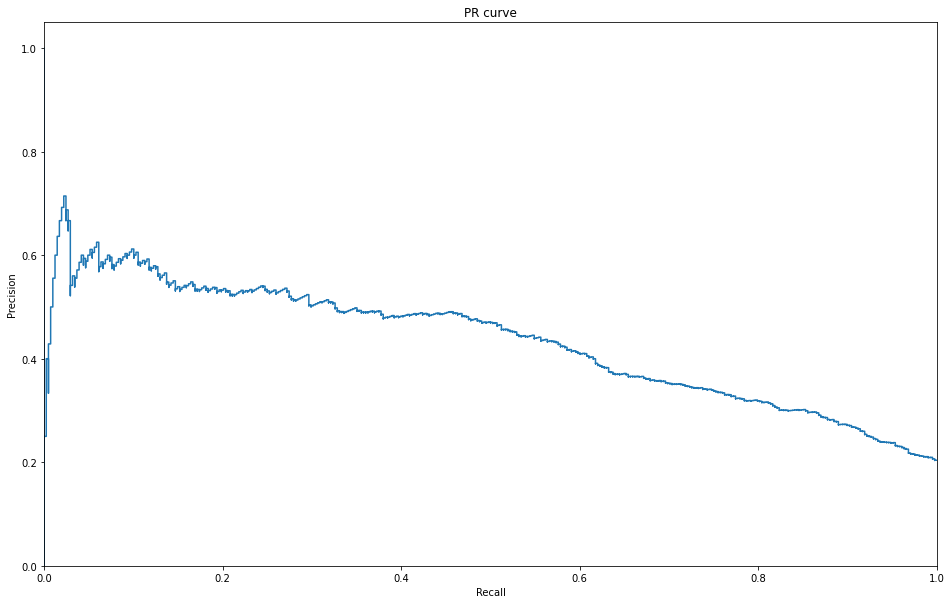

In [19]:
print_pr_curve(best_lin_reg_classifier, best_lin_reg_features, valid_features, valid_target)

### Обучение на расширенной выборке

Что касается расширенной и суженной (укороченной выборки, а не невесты) выборок - здесь нам нужно обучиться на модифицированных выборках с одинаковым количеством классов, а проверить метрики на выборках с дисбалансом классов. Так как GridCearchCV (как и все остальные классы sklearn, проводящие перебор параметров) выбирают наилучший класс с гиперпараметрами с учетом кросс-валидации поданного ей на вход набора данных (то есть, обучающая и валидационная выборка будут нарезаны классом самостоятельно), мы не сможем модифицировать только обучающую выборку. Поэтому нам придется руками реализовать собственный Grid Search, который решит поставленную задачу.

#### Случайный лес

Производим перебор по тому же самому набору гиперпараметров, что и раньше

In [20]:
# Функция, которая для словаря множества аргументов создаст список всевозможных комбинаций аргументов
def product_dict(inp):
    return [dict(zip(inp.keys(), values)) for values in product(*inp.values())]

In [21]:
random_forest_up_param = []
random_forest_up_feat = []

if is_need_learn == True:
    next_it = True
    cur_best_model_score = -1
    cur_features_list = features_list
    
    while next_it or len(cur_features_list) < 1:
        next_it = False
        iter_best_model_score = -1
        iter_best_model_feat = []
        
        for feat in cur_features_list:
            print(feat)
            feat_score = -1
            feat_param = []
            
            parameters_random_forest = {
                'n_estimators' : range(500, 1000, 50),
                'class_weight' : ['balanced', None],
                'max_features' : range(1, len(feat) + 1),
                'criterion': ['gini'],
                'max_depth' : range(10, 80, 5),
            }

            kwarg_params = product_dict(parameters_random_forest)

            for param in kwarg_params:
                classifier = RandomForestClassifier(**param)
                classifier.fit(features_upsampled[feat], target_upsampled)
                predicted = classifier.predict(valid_features[feat])
                f1_val = f1_score(valid_target, predicted)
                if f1_val > feat_score:
                    feat_score = f1_val
                    feat_param = param
                
            random_forest_up_param.append(feat_param)
            random_forest_up_feat.append(feat)
            if feat_score > iter_best_model_score:
                iter_best_model_score = feat_score
                iter_best_model_feat = feat
                print('Best F1-score:', iter_best_model_score)
        
        if iter_best_model_score > cur_best_model_score:
            cur_best_model_score = iter_best_model_score
            next_it = True
            
            # generate new features list
            cur_features_list = []
            comb = list(combinations(feat, len(feat) - 1))
            for a in comb:
                cur_features_list.append(list(a))


Посмотрим на результаты наилучшей модели на несбалансированной обучающей выборке. Помимо F1 метрики также посмотрим на AUC-ROC (площадь под roc-curve).

In [22]:
if is_need_learn != True:
    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 61, 'max_features': 2, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])
    
    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 51, 'max_features': 2, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain'])
    
    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 111, 'max_features': 3, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Gender_Male'])
    
    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 71, 'max_features': 2, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Spain', 'Gender_Male'])
    
    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 51, 'max_features': 3, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])
    
    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 141, 'max_features': 2, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])
    
    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 131, 'max_features': 1, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])
    
    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 41, 'max_features': 5, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])
    
    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 101, 'max_features': 3, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 91, 'max_features': 3, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 21, 'max_features': 7, 'criterion': 'gini', 'max_depth': 6})
    random_forest_up_feat.append(['CreditScore', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 51, 'max_features': 3, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 51, 'max_features': 1, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain'])

    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 41, 'max_features': 4, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Gender_Male'])

    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 91, 'max_features': 3, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Spain', 'Gender_Male'])

    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 61, 'max_features': 2, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 31, 'max_features': 2, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 111, 'max_features': 2, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 121, 'max_features': 3, 'criterion': 'gini', 'max_depth': 6})
    random_forest_up_feat.append(['Age', 'Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 101, 'max_features': 2, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 51, 'max_features': 2, 'criterion': 'gini', 'max_depth': 11})
    random_forest_up_feat.append(['Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_up_param.append({'random_state' : 12345, 'n_estimators': 91, 'max_features': 6, 'criterion': 'gini', 'max_depth': 6})
    random_forest_up_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

random_forest_up_models = []
random_forest_up_best_score = -1
random_forest_up_best_ind = -1
auc_roc_score = -1

for i in range(len(random_forest_up_param)):
    classifier = RandomForestClassifier(**random_forest_up_param[i])
    features = random_forest_up_feat[i]
    classifier.fit(features_upsampled[features], target_upsampled)
    random_forest_up_models.append(classifier)
    predicted_target = classifier.predict(valid_features[features])
    cur_score = f1_score(valid_target, predicted_target)
    if (cur_score > random_forest_up_best_score):
        random_forest_up_best_score = cur_score
        random_forest_up_best_ind = i
        auc_roc_score = roc_auc_score(valid_target, predicted_target)
    
print('Best model')
print(random_forest_up_models[random_forest_up_best_ind])
print('F1 score on train and valid data:', random_forest_up_best_score)
print('AUC-ROC score:', auc_roc_score)
print('Features:')
print(random_forest_up_feat[random_forest_up_best_ind])

Best model
RandomForestClassifier(max_depth=11, max_features=2, n_estimators=61,
                       random_state=12345)
F1 score on train and valid data: 0.6022727272727273
AUC-ROC score: 0.7597831505483549
Features:
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']


#### Логистическая регрессия

Производим перебор по тому же самому набору гиперпараметров, что и раньше

In [23]:
lin_reg_up_param = []
lin_reg_up_feat = []

if is_need_learn == True:
    next_it = True
    cur_best_model_score = -1
    cur_features_list = features_list
    
    while next_it or len(cur_features_list) < 1:
        next_it = False
        iter_best_model_score = -1
        iter_best_model_feat = []
        
        for feat in cur_features_list:
            print(feat)
            feat_score = -1
            feat_param = []
            
            parameters_log_reg = {
                'random_state' : [12345],
                'solver' : ['lbfgs', 'sag', 'saga'],
                'max_iter' : [10000],
                'C' : np.logspace(-2, 3, 200)
            }
            kwarg_params = product_dict(parameters_log_reg)

            for param in kwarg_params:
                classifier = LogisticRegression(**param)
                classifier.fit(features_upsampled[feat], target_upsampled)
                predicted = classifier.predict(valid_features[feat])
                f1_val = f1_score(valid_target, predicted)
                if f1_val > feat_score:
                    feat_score = f1_val
                    feat_param = param
                
            lin_reg_up_param.append(feat_param)
            lin_reg_up_feat.append(feat)
            if feat_score > iter_best_model_score:
                iter_best_model_score = feat_score
                iter_best_model_feat = feat
                print('Best F1-score:', iter_best_model_score)
        
        if iter_best_model_score > cur_best_model_score:
            cur_best_model_score = iter_best_model_score
            next_it = True
            
            # generate new features list
            cur_features_list = []
            comb = list(combinations(feat, len(feat) - 1))
            for a in comb:
                cur_features_list.append(list(a))


Посмотрим на результаты наилучшей модели на несбалансированной обучающей выборке. Помимо F1 метрики также посмотрим на AUC-ROC (площадь под roc-curve).

In [24]:
if is_need_learn != True:
    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.04500557675700498})
    lin_reg_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.01})
    lin_reg_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.023816855519761582})
    lin_reg_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.011226677735108135})
    lin_reg_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.017834308769319095})
    lin_reg_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.01})
    lin_reg_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.010595601792776159})
    lin_reg_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'saga', 'max_iter': 10000, 'C': 0.02247805833548725})
    lin_reg_up_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.011226677735108135})
    lin_reg_up_feat.append(['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'sag', 'max_iter': 10000, 'C': 0.01})
    lin_reg_up_feat.append(['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 2.171117945694505})
    lin_reg_up_feat.append(['CreditScore', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.020022003718155844})
    lin_reg_up_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.01})
    lin_reg_up_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.023816855519761582})
    lin_reg_up_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.013354515629298987})
    lin_reg_up_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.04768611697714469})
    lin_reg_up_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.016831803533309566})
    lin_reg_up_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.8603464416684504})
    lin_reg_up_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.02523539170434766})
    lin_reg_up_feat.append(['Age', 'Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.012603829296797275})
    lin_reg_up_feat.append(['Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.015885651294280528})
    lin_reg_up_feat.append(['Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.014992684327860457})
    lin_reg_up_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.3217641750250737})
    lin_reg_up_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.01})
    lin_reg_up_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.16070528182616392})
    lin_reg_up_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.010595601792776159})
    lin_reg_up_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.011895340673703195})
    lin_reg_up_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.01})
    lin_reg_up_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.021214517849106298})
    lin_reg_up_feat.append(['Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'sag', 'max_iter': 10000, 'C': 0.06010276782070382})
    lin_reg_up_feat.append(['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_up_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.017834308769319095})
    lin_reg_up_feat.append(['Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    
lin_reg_up_models = []
lin_reg_up_best_score = -1
lin_reg_up_best_ind = -1
auc_roc_score = -1

for i in range(len(lin_reg_up_param)):
    classifier = LogisticRegression(**lin_reg_up_param[i])
    features = lin_reg_up_feat[i]
    classifier.fit(features_upsampled[features], target_upsampled)
    lin_reg_up_models.append(classifier)
    predicted_target = classifier.predict(valid_features[features])
    cur_score = f1_score(valid_target, predicted_target)
    if (cur_score > lin_reg_up_best_score):
        lin_reg_up_best_score = cur_score
        lin_reg_up_best_ind = i
        auc_roc_score = roc_auc_score(valid_target, predicted_target)
    
print('Best model')
print(lin_reg_up_models[lin_reg_up_best_ind])
print('F1 score on train and valid data:', lin_reg_up_best_score)
print('AUC-ROC score:', auc_roc_score)
print('Features:')
print(lin_reg_up_feat[lin_reg_up_best_ind])

Best model
LogisticRegression(C=0.016831803533309566, max_iter=10000, random_state=12345)
F1 score on train and valid data: 0.48490077653149266
AUC-ROC score: 0.6968423433403493
Features:
['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']


Threshold = 0.00 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.05 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.10 | Precision = 0.204, Recall = 0.998 | F1-score = 0.339
Threshold = 0.15 | Precision = 0.208, Recall = 0.995 | F1-score = 0.343
Threshold = 0.20 | Precision = 0.216, Recall = 0.980 | F1-score = 0.354
Threshold = 0.25 | Precision = 0.228, Recall = 0.956 | F1-score = 0.368
Threshold = 0.30 | Precision = 0.251, Recall = 0.924 | F1-score = 0.395
Threshold = 0.35 | Precision = 0.274, Recall = 0.880 | F1-score = 0.418
Threshold = 0.40 | Precision = 0.307, Recall = 0.826 | F1-score = 0.448
Threshold = 0.45 | Precision = 0.335, Recall = 0.752 | F1-score = 0.464
Threshold = 0.50 | Precision = 0.374, Recall = 0.689 | F1-score = 0.485
Threshold = 0.55 | Precision = 0.402, Recall = 0.600 | F1-score = 0.481
Threshold = 0.60 | Precision = 0.403, Recall = 0.478 | F1-score = 0.437
Threshold = 0.65 | Precision = 0.436, Recall = 0.387 | F1-score 

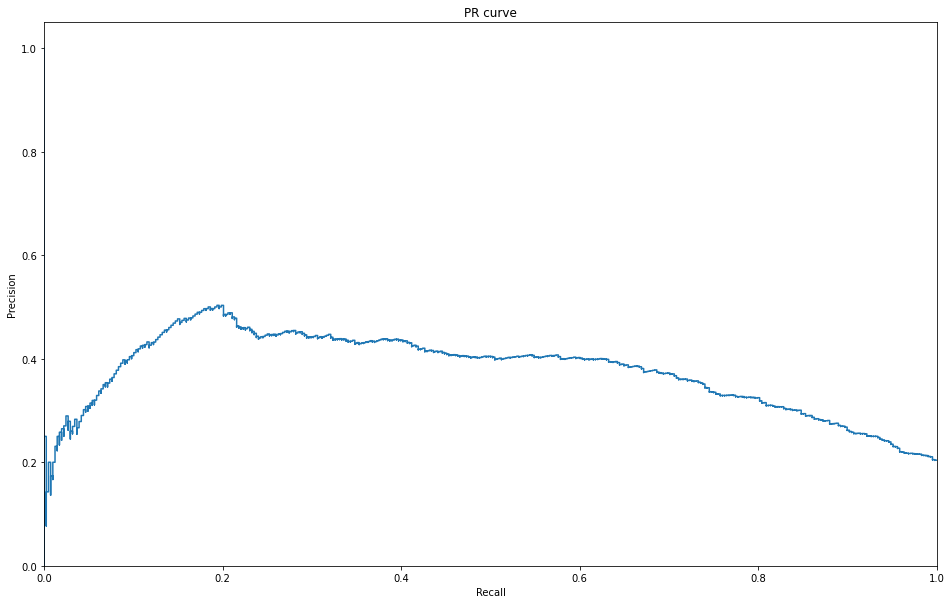

In [25]:
print_pr_curve(lin_reg_up_models[lin_reg_up_best_ind], lin_reg_up_feat[lin_reg_up_best_ind], valid_features, valid_target)

### Обучение на суженной выборке

#### Случайный лес

Ничего не изменилось. Так же, как и в случае с расширенной выборкой, производим перебор самописным GridSearch по тому же самому набору гиперпараметров, что и все предыдущие разы.

In [26]:
random_forest_down_param = []
random_forest_down_feat = []

if is_need_learn == True:
    next_it = True
    cur_best_model_score = -1
    cur_features_list = features_list
    
    while next_it or len(cur_features_list) < 1:
        next_it = False
        iter_best_model_score = -1
        iter_best_model_feat = []
        
        for feat in cur_features_list:
            print(feat)
            feat_score = -1
            feat_param = []
            
            parameters_random_forest = {
                'n_estimators' : range(500, 1000, 50),
                'class_weight' : ['balanced', None],
                'max_features' : range(1, len(feat) + 1),
                'criterion': ['gini'],
                'max_depth' : range(10, 80, 5),
            }

            kwarg_params = product_dict(parameters_random_forest)

            for param in kwarg_params:
                classifier = RandomForestClassifier(**param)
                classifier.fit(features_downsampled[feat], target_downsampled)
                predicted = classifier.predict(valid_features[feat])
                f1_val = f1_score(valid_target, predicted)
                if f1_val > feat_score:
                    feat_score = f1_val
                    feat_param = param
                
            random_forest_down_param.append(feat_param)
            random_forest_down_feat.append(feat)
            if feat_score > iter_best_model_score:
                iter_best_model_score = feat_score
                iter_best_model_feat = feat
                print('Best F1-score:', iter_best_model_score)
        
        if iter_best_model_score > cur_best_model_score:
            cur_best_model_score = iter_best_model_score
            next_it = True
            
            # generate new features list
            cur_features_list = []
            comb = list(combinations(feat, len(feat) - 1))
            for a in comb:
                cur_features_list.append(list(a))


Посмотрим на результаты наилучшей модели на несбалансированной обучающей выборке. Помимо F1 метрики также посмотрим на AUC-ROC (площадь под roc-curve).

In [27]:
best_random_forest_down_classifier_param = None
best_random_forest_down_features = []

if is_need_learn != True:
    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 121, 'max_features': 5, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 61, 'max_features': 8, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 71, 'max_features': 5, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 51, 'max_features': 8, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 141, 'max_features': 6, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 121, 'max_features': 6, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 51, 'max_features': 8, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 51, 'max_features': 4, 'criterion': 'gini', 'max_depth': 11})
    random_forest_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 81, 'max_features': 3, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 31, 'max_features': 5, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 21, 'max_features': 7, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['CreditScore', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 141, 'max_features': 6, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 101, 'max_features': 7, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 131, 'max_features': 3, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 61, 'max_features': 8, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 111, 'max_features': 4, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 121, 'max_features': 8, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 131, 'max_features': 4, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 41, 'max_features': 2, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Age', 'Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 11, 'max_features': 7, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 121, 'max_features': 6, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 141, 'max_features': 6, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 61, 'max_features': 7, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 71, 'max_features': 6, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 31, 'max_features': 6, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 91, 'max_features': 7, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 141, 'max_features': 6, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 111, 'max_features': 5, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 61, 'max_features': 3, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 51, 'max_features': 8, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    random_forest_down_param.append({'random_state' : 12345, 'n_estimators': 51, 'max_features': 5, 'criterion': 'gini', 'max_depth': 6})
    random_forest_down_feat.append(['Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    
    
random_forest_down_models = []
random_forest_down_best_score = -1
random_forest_down_best_ind = -1
auc_roc_score = -1

for i in range(len(random_forest_down_param)):
    classifier = RandomForestClassifier(**random_forest_down_param[i])
    features = random_forest_down_feat[i]
    classifier.fit(features_downsampled[features], target_downsampled)
    random_forest_down_models.append(classifier)
    predicted_target = classifier.predict(valid_features[features])
    cur_score = f1_score(valid_target, predicted_target)
    if (cur_score > random_forest_down_best_score):
        random_forest_down_best_score = cur_score
        random_forest_down_best_ind = i
        auc_roc_score = roc_auc_score(valid_target, predicted_target)
    
print('Best model')
print(random_forest_down_models[random_forest_down_best_ind])
print('F1 score on train and valid data:', random_forest_down_best_score)
print('AUC-ROC score:', auc_roc_score)
print('Features:')
print(random_forest_down_feat[random_forest_down_best_ind])

Best model
RandomForestClassifier(max_depth=6, max_features=6, n_estimators=121,
                       random_state=12345)
F1 score on train and valid data: 0.593170731707317
AUC-ROC score: 0.7743067095011262
Features:
['Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']


#### Логистическая регрессия

Ничего не изменилось. Так же, как и в случае с расширенной выборкой, производим перебор самописным GridSearch по тому же самому набору гиперпараметров, что и все предыдущие разы.

In [28]:
lin_reg_down_param = []
lin_reg_down_feat = []

if is_need_learn == True:
    next_it = True
    cur_best_model_score = -1
    cur_features_list = features_list
    
    while next_it or len(cur_features_list) < 1:
        next_it = False
        iter_best_model_score = -1
        iter_best_model_feat = []
        
        for feat in cur_features_list:
            print(feat)
            feat_score = -1
            feat_param = []

            parameters_log_reg = {
                'random_state' : [12345],
                'solver' : ['lbfgs', 'sag', 'saga'],
                'max_iter' : [10000],
                'C' : np.logspace(-2, 4, 200)
            }
            kwarg_params = product_dict(parameters_log_reg)

            for param in kwarg_params:
                classifier = LogisticRegression(**param)
                classifier.fit(features_downsampled[feat], target_downsampled)
                predicted = classifier.predict(valid_features[feat])
                f1_val = f1_score(valid_target, predicted)
                if f1_val > feat_score:
                    feat_score = f1_val
                    feat_param = param
                
            lin_reg_down_param.append(feat_param)
            lin_reg_down_feat.append(feat)
            if feat_score > iter_best_model_score:
                iter_best_model_score = feat_score
                iter_best_model_feat = feat
                print('Best F1-score:', iter_best_model_score)
        
        if iter_best_model_score > cur_best_model_score:
            cur_best_model_score = iter_best_model_score
            next_it = True
            
            # generate new features list
            cur_features_list = []
            comb = list(combinations(feat, len(feat) - 1))
            for a in comb:
                cur_features_list.append(list(a))


Посмотрим на результаты наилучшей модели на несбалансированной обучающей выборке. Помимо F1 метрики также посмотрим на AUC-ROC (площадь под roc-curve).

In [29]:
if is_need_learn != True:
    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.04008806328898465})
    lin_reg_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.01})
    lin_reg_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.02300430119772918})
    lin_reg_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.011489510001873092})
    lin_reg_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.0174263338600965})
    lin_reg_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.01})
    lin_reg_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])
                            
    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.010718913192051276})
    lin_reg_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.02300430119772918})
    lin_reg_down_feat.append(['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.010718913192051276})
    lin_reg_down_feat.append(['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'sag', 'max_iter': 10000, 'C': 0.01})
    lin_reg_down_feat.append(['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 2.247805833548725})
    lin_reg_down_feat.append(['CreditScore', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.020022003718155844})
    lin_reg_down_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.012315506032928256})
    lin_reg_down_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'saga', 'max_iter': 10000, 'C': 0.024658110758226028})
    lin_reg_down_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.01320088400831418})
    lin_reg_down_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Spain', 'Gender_Male'])
                            
    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.049370478528390035})
    lin_reg_down_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.015167168884709226})
    lin_reg_down_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.8504489341802677})
    lin_reg_down_feat.append(['Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.02300430119772918})
    lin_reg_down_feat.append(['Age', 'Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.01320088400831418})
    lin_reg_down_feat.append(['Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.015167168884709226})
    lin_reg_down_feat.append(['Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.015167168884709226})
    lin_reg_down_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.32176417502507354})
    lin_reg_down_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.01})
    lin_reg_down_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.16070528182616384})
    lin_reg_down_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.010718913192051276})
    lin_reg_down_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.010718913192051276})
    lin_reg_down_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.01})
    lin_reg_down_feat.append(['Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.021461411978584036})
    lin_reg_down_feat.append(['Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.06080224261649421})
    lin_reg_down_feat.append(['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

    lin_reg_down_param.append({'random_state' : 12345, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 0.0174263338600965})
    lin_reg_down_feat.append(['Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

lin_reg_down_models = []
lin_reg_down_best_score = -1
lin_reg_down_best_ind = -1
auc_roc_score = -1

for i in range(len(lin_reg_down_param)):
    classifier = LogisticRegression(**lin_reg_down_param[i])
    features = lin_reg_down_feat[i]
    classifier.fit(features_downsampled[features], target_downsampled)
    lin_reg_down_models.append(classifier)
    predicted_target = classifier.predict(valid_features[features])
    cur_score = f1_score(valid_target, predicted_target)
    if (cur_score > lin_reg_down_best_score):
        lin_reg_down_best_score = cur_score
        lin_reg_down_best_ind = i
        auc_roc_score = roc_auc_score(valid_target, predicted_target)
    
print('Best model')
print(lin_reg_down_models[lin_reg_down_best_ind])
print('F1 score on train and valid data:', lin_reg_down_best_score)
print('AUC-ROC score:', auc_roc_score)
print('Features:')
print(lin_reg_down_feat[lin_reg_down_best_ind])

Best model
LogisticRegression(C=0.011489510001873092, max_iter=10000, random_state=12345)
F1 score on train and valid data: 0.49691629955947136
AUC-ROC score: 0.7059146634171559
Features:
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Spain', 'Gender_Male']


Посмотрим на результаты наилучшей модели на несбалансированной обучающей выборке. Помимо F1 метрики также посмотрим на AUC-ROC (площадь под roc-curve).

Threshold = 0.00 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.05 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.10 | Precision = 0.204, Recall = 0.998 | F1-score = 0.339
Threshold = 0.15 | Precision = 0.206, Recall = 0.995 | F1-score = 0.341
Threshold = 0.20 | Precision = 0.212, Recall = 0.985 | F1-score = 0.349
Threshold = 0.25 | Precision = 0.225, Recall = 0.963 | F1-score = 0.365
Threshold = 0.30 | Precision = 0.244, Recall = 0.936 | F1-score = 0.387
Threshold = 0.35 | Precision = 0.273, Recall = 0.902 | F1-score = 0.419
Threshold = 0.40 | Precision = 0.299, Recall = 0.824 | F1-score = 0.439
Threshold = 0.45 | Precision = 0.341, Recall = 0.767 | F1-score = 0.472
Threshold = 0.50 | Precision = 0.388, Recall = 0.691 | F1-score = 0.497
Threshold = 0.55 | Precision = 0.420, Recall = 0.578 | F1-score = 0.487
Threshold = 0.60 | Precision = 0.463, Recall = 0.480 | F1-score = 0.472
Threshold = 0.65 | Precision = 0.473, Recall = 0.360 | F1-score 

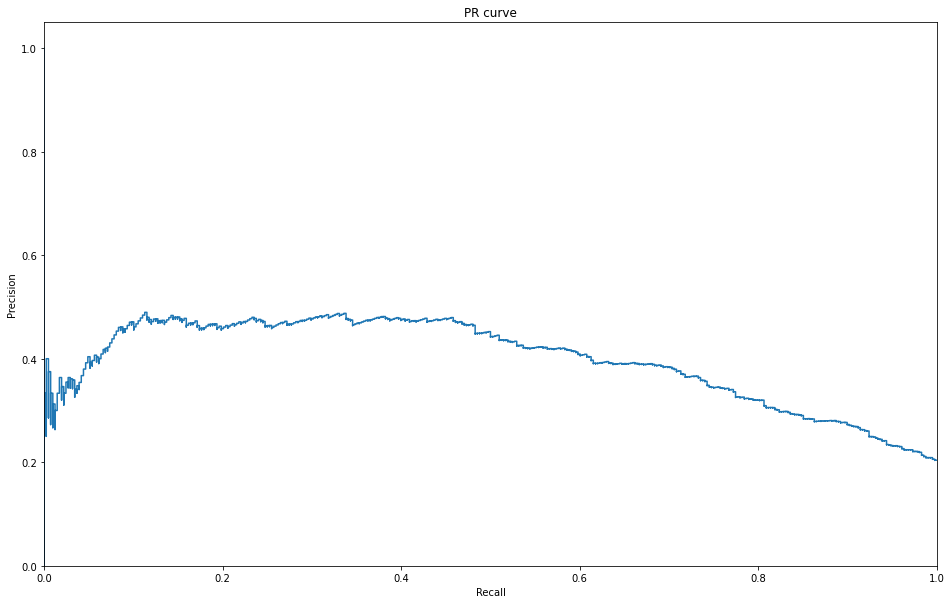

In [30]:
print_pr_curve(lin_reg_down_models[lin_reg_down_best_ind], lin_reg_down_feat[lin_reg_down_best_ind], valid_features, valid_target)

### Вывод

Не очень хотелось писать общие одинаковые слова по каждому измерению и графику, поэтому напишу общий вывод по всем исследованиям моделей.

* Значений F1-score для лучших моделей случайного леса колеблются в районе 0.59 - 0.61. На сбалансированных выборках вроде бы чуть лучше - но на самом деле нет. Разницы в 0.01-0.02 можно добиться даже обычным изменением параметра random_state при обучении модели или при разбиении выборки. Я не стал делать показательный перебор в этой работе, но игрался с этим параметром - различия действительно немаленькие по сравнения с различиями в моделях, обученных на разных данных. Нужна некоторая метрика для оценки погрешности наших моделей - но я, к сожалению, _пока не шарю_

* При обучении на несбалансированных выборках мы использовали гиперпараметр class_weight, который делает примерно то же самое, что и расширение/сужение выборки - сглаживает несбалансированность классов. Как следствие, мы имеем довольно схожие (схожесть в рамках описанного в предыдущем пункте) результаты для сбалансированных и несбалансированных выборок.

* Линейная регрессия показывает ужасные результаты. Не знаю, почему мне так не везет, но это не первый отчет, где метрика на модели данного алгоритма у меня хуже некуда. Я смотрю видео крутых аналитиков, которые рассказывают, что в каких-то отраслях линейная регрессия - это круто. Я читаю отчеты на kaggle (даже на этом наборе данных) - ребята получают адекватные значения метрик, практически не трогая гиперпараметры, а только лишь угадывая хороший random_state - и получают хороший результат. Не знаю, почему мне так не везет:)

* На некоторых моделях видно, что у одной F1 выше, а AUC-ROC при этом ниже. Разница при этом не фатальная, что говорит о тонком различии между этими метриками, которое можно использовать в различных задачах (в зависимости от веса определенных ошибок).

## Тестирование полученных моделей

Тестирование будем проводить следующим образом.
* наилучшие модели, полученные при обучении на несбалансированных выборках, будем проверять, обучая на несбалансированных выборках - объединении обучающей и валидационной, а проверять на несбалансированной тестовой.
* наилучшие модели, полученные при обучении на сбалансированных выборках, будем проверять, обучая на соответствущим образом сбалансированных выборках (расширенных или суженных), а проверять также на несбалансированной тестовой.

Для этого создадим расширенные и суженные версии объединения обучающей и валидационной выборок

In [31]:
main_features_upsampled, main_target_upsampled = upsample(main_features, main_target, 4)
print('Upsampled train sample size', main_features_upsampled.shape[0])
print('Class 1', main_features_upsampled[main_target_upsampled == 1].shape[0])
print('Class 2', main_features_upsampled[main_target_upsampled == 0].shape[0])

Upsampled train sample size 12886
Class 1 6516
Class 2 6370


In [32]:
main_features_downsampled, main_target_downsampled = downsample(main_features, main_target, 0.26)
print('Downsampled train sample size', main_features_downsampled.shape[0])
print('Class 1', main_features_downsampled[main_target_downsampled == 1].shape[0])
print('Class 2', main_features_downsampled[main_target_downsampled == 0].shape[0])

Downsampled train sample size 3285
Class 1 1629
Class 2 1656


Проверим также наши модели на "адекватность", сравнив их точности с простыми классификаторами. Первый простой классификатор будет выдавать константный ответ, равный самому популярному ответу в обучающей выборке, а второй - выдавать ответы согласно распределению такому же, какое было среди элементов обучающей выборки.

In [33]:
dummy_model_1 = DummyClassifier(random_state=12345, strategy='stratified').fit(main_features, main_target)
test_predictions = dummy_model_1.predict(test_features)
print('First dummy f1 score', f1_score(test_target, test_predictions))
print('First dummy auc-roc score', roc_auc_score(test_target, test_predictions))

dummy_model_2 = DummyClassifier(random_state=12345, strategy='most_frequent').fit(main_features, main_target)
test_predictions = dummy_model_2.predict(test_features)
print('Second dummy f1 score', f1_score(test_target, test_predictions))
print('Second dummy auc-roc score', roc_auc_score(test_target, test_predictions))

First dummy f1 score 0.19417475728155342
First dummy auc-roc score 0.4925778220892877
Second dummy f1 score 0.0
Second dummy auc-roc score 0.5


#### Случайный лес

In [34]:
best_random_forest_classifier = RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=6,
                       n_estimators=31, random_state=12345)
best_random_forest_classifier.fit(main_features[best_random_forest_features], main_target)
predicted_target = best_random_forest_classifier.predict(test_features[best_random_forest_features])
print('F1 score:', f1_score(test_target, predicted_target))
print('AUC-ROC score:', roc_auc_score(test_target, predicted_target))

F1 score: 0.617408906882591
AUC-ROC score: 0.7874593811159115


In [35]:
best_random_forest_classifier = RandomForestClassifier(**random_forest_up_param[random_forest_up_best_ind])
best_random_forest_classifier.fit(main_features_upsampled[random_forest_up_feat[random_forest_up_best_ind]], main_target_upsampled)
predicted_target = best_random_forest_classifier.predict(test_features[random_forest_up_feat[random_forest_up_best_ind]])
print('F1 score:', f1_score(test_target, predicted_target))
print('AUC-ROC score:', roc_auc_score(test_target, predicted_target))

F1 score: 0.6355555555555555
AUC-ROC score: 0.7858323178612311


In [36]:
best_random_forest_classifier = RandomForestClassifier(**random_forest_down_param[random_forest_down_best_ind])
best_random_forest_classifier.fit(main_features_downsampled[random_forest_down_feat[random_forest_down_best_ind]], main_target_downsampled)
predicted_target = best_random_forest_classifier.predict(test_features[random_forest_down_feat[random_forest_down_best_ind]])
print('F1 score:', f1_score(test_target, predicted_target))
print('AUC-ROC score:', roc_auc_score(test_target, predicted_target))

F1 score: 0.6104023552502453
AUC-ROC score: 0.7869654924116539


#### Логистическая регрессия

In [37]:
best_lin_reg_classifier = LogisticRegression(class_weight='balanced', solver='lbfgs', 
                                                 max_iter=10000, random_state=12345)
best_lin_reg_classifier.fit(main_features[best_lin_reg_features], main_target)
predicted_target = best_lin_reg_classifier.predict(test_features[best_lin_reg_features])
print('F1 score:', f1_score(test_target, predicted_target))
print('AUC-ROC score:', roc_auc_score(test_target, predicted_target))

F1 score: 0.33872976338729766
AUC-ROC score: 0.5


Threshold = 0.00 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.05 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.10 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.15 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.20 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.25 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.30 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.35 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.40 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.45 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.50 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.55 | Precision = 0.234, Recall = 0.446 | F1-score = 0.307
Threshold = 0.60 | Precision = 0.000, Recall = 0.000 | F1-score = 0.000
Threshold = 0.65 | Precision = 0.000, Recall = 0.000 | F1-score 

/home/bloodless/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bloodless/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bloodless/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bloodless/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: Un

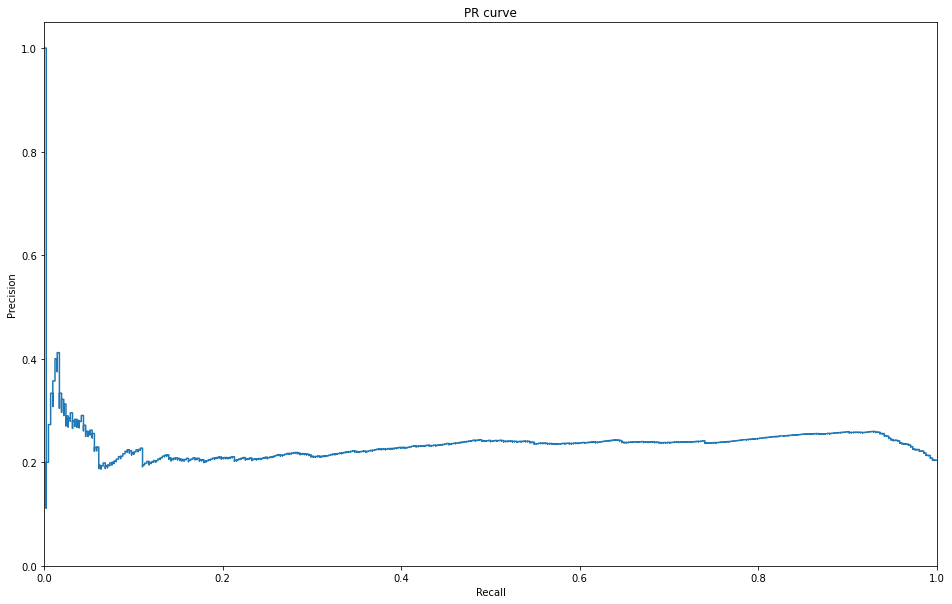

In [38]:
print_pr_curve(best_lin_reg_classifier, best_lin_reg_features, test_features, test_target)

In [39]:
best_lin_reg_classifier = LogisticRegression(**lin_reg_up_param[lin_reg_up_best_ind])
best_lin_reg_classifier.fit(main_features_upsampled[lin_reg_up_feat[lin_reg_up_best_ind]], main_target_upsampled)
predicted_target = best_lin_reg_classifier.predict(test_features[lin_reg_up_feat[lin_reg_up_best_ind]])
print('F1 score:', f1_score(test_target, predicted_target))
print('AUC-ROC score:', roc_auc_score(test_target, predicted_target))

F1 score: 0.35894495412844035
AUC-ROC score: 0.5624861526531516


Threshold = 0.00 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.05 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.10 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.15 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.20 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.25 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.30 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.35 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.40 | Precision = 0.207, Recall = 0.995 | F1-score = 0.343
Threshold = 0.45 | Precision = 0.218, Recall = 0.934 | F1-score = 0.354
Threshold = 0.50 | Precision = 0.234, Recall = 0.767 | F1-score = 0.359
Threshold = 0.55 | Precision = 0.248, Recall = 0.525 | F1-score = 0.336
Threshold = 0.60 | Precision = 0.327, Recall = 0.316 | F1-score = 0.322
Threshold = 0.65 | Precision = 0.453, Recall = 0.096 | F1-score 

/home/bloodless/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bloodless/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bloodless/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bloodless/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: Un

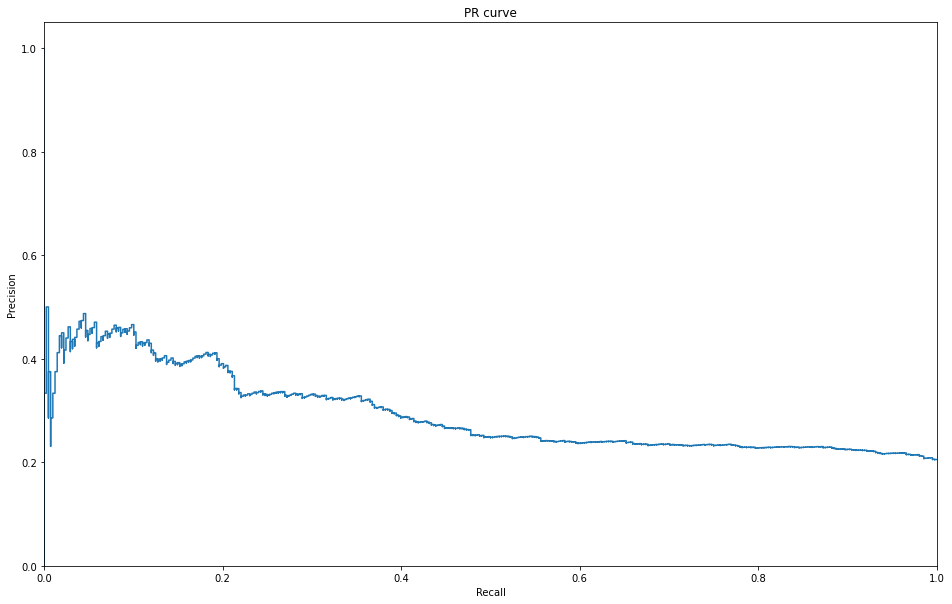

In [40]:
print_pr_curve(best_lin_reg_classifier, lin_reg_up_feat[lin_reg_up_best_ind], test_features, test_target)

In [41]:
best_lin_reg_classifier = LogisticRegression(**lin_reg_down_param[lin_reg_down_best_ind])
best_lin_reg_classifier.fit(main_features_downsampled[lin_reg_down_feat[lin_reg_down_best_ind]], main_target_downsampled)
predicted_target = best_lin_reg_classifier.predict(test_features[lin_reg_down_feat[lin_reg_down_best_ind]])
print('F1 score:', f1_score(test_target, predicted_target))
print('AUC-ROC score:', roc_auc_score(test_target, predicted_target))

F1 score: 0.45257903494176377
AUC-ROC score: 0.6694915254237288


Threshold = 0.00 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.05 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.10 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.15 | Precision = 0.204, Recall = 1.000 | F1-score = 0.339
Threshold = 0.20 | Precision = 0.207, Recall = 0.993 | F1-score = 0.343
Threshold = 0.25 | Precision = 0.216, Recall = 0.985 | F1-score = 0.354
Threshold = 0.30 | Precision = 0.231, Recall = 0.968 | F1-score = 0.373
Threshold = 0.35 | Precision = 0.251, Recall = 0.919 | F1-score = 0.394
Threshold = 0.40 | Precision = 0.278, Recall = 0.853 | F1-score = 0.419
Threshold = 0.45 | Precision = 0.312, Recall = 0.770 | F1-score = 0.444
Threshold = 0.50 | Precision = 0.343, Recall = 0.667 | F1-score = 0.453
Threshold = 0.55 | Precision = 0.380, Recall = 0.551 | F1-score = 0.450
Threshold = 0.60 | Precision = 0.408, Recall = 0.436 | F1-score = 0.422
Threshold = 0.65 | Precision = 0.451, Recall = 0.319 | F1-score 

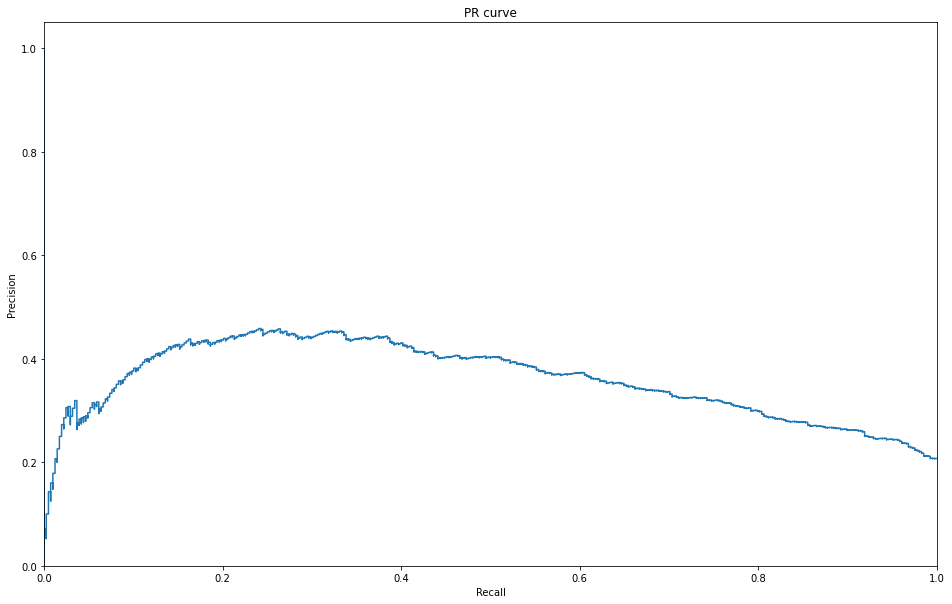

In [42]:
print_pr_curve(best_lin_reg_classifier, lin_reg_down_feat[lin_reg_down_best_ind], test_features, test_target)

## Общий вывод

Была проделана невероятная по объему работа!

Были изучены данные. Выбраны признаки классификации и целевой признак. Для категориальных признаков было осуществлено преобразование в целочисленные методом OHE, для целочисленных - нормализация. Было определено соотношение классов и необходимость учитывания несбалансированности классов при обучении.

Были выбраны два алгоритма машинных обучения (случайный лес и логистическая регрессия) и их реализации в библиотеке sci-kit learn. Для каждой реализации был подобран набор гиперпараметров. Был разработан алгоритм перебора признаков для определения оптимального. Для каждого набора гиперпараметров с использованием алгоритма перебора признаков были обучены на тестовой выборке модели. Проверка качества модели производилась кросс-валидацией с 2 делениями. Для каждого алгоритма была определена модель, показывающая лучшее значение точности (f1) на обучающей выборке, превышающая при этом заранее определенную границу 0.59. Такой оказалась лишь модель случайного леса.

Также были проведены поиски наилучшей модели с тем же пространством гиперпараметров и тем же алгоритмом перебора комбинаций признаков, но обученные на двух видах сбалансированных выборок - расширенной и суженной. Результаты были схожи - наилучшая модель случайного леса немного превышала указанный в условии порог 0.59 (0.6), наилучшая модель логистической регрессии была сильно хуже (0.49).

Для каждой наилучшей модели вычислено значение метрики AUC-ROC. Для моделей логистической регрессии было проведено исследование значений f1-метрики на основании различных значений порога классификации.

Как итог - была выбрана и обучена наилучшая модель с f1-метрикой свыше 0.59 (а именно модель случайного леса со значением метрики 0.63). Исходная задача полностью выполнена.